## fit the power-law distribution with exponential cutoff

We try to fit the following form
$$
y_{\rm model} = \frac{dN}{d\log_{10}x}= 10^A x^{-\beta}\exp (-x/x_c)
$$

$A$, $\beta$, $x_c$ all have uncertainty

The Poisson's liklihood function is
$$
\ln L = \sum_i -y_{\rm model} - \ln(y_i!) + y_i\ln y_{\rm model}
$$

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import factorial, gammaln
from scipy.integrate import quad

import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def powerlaw_expcutoff(p, logx):
    A = p[0]
    beta = p[1]
    logxc = p[2]
    
    x = 10**logx
    xc = 10**logxc
    return 10**A * x**(-beta) * np.exp(-x/xc)

def get_A(beta, logxc, logxmin, size, dlogx):
    func = lambda logx: powerlaw_expcutoff([0, beta, logxc], logx)
    return np.log10(size*dlogx / quad(func, logxmin, 10)[0])

def neg_log_poisson_likelihood(p, logx, y):
    ymodel = powerlaw_expcutoff(p, logx)
    return -np.sum(-ymodel-gammaln(y+1)+np.log(ymodel)*y)

In [3]:
# generate test data

def sample_powerlaw_expcutoff(rng, logxmin=2, beta=2, logxc=3, size=10000):
    # ChatGPT made this. I don't know if it's correct
    xc = 10**logxc
    samples = []
    while len(samples) < size:
        x = 10**logxmin * (1 - rng.random()) ** (-1 / (beta - 1))

        accept_prob = np.exp(-x / 10**logxc)

        if rng.random() < accept_prob:
            samples.append(x)

    return np.array(samples)


rng = np.random.default_rng(0)

size = 1000
logxmin = 2
beta_true = 1 # beta here is the slope of dN/dlogx, not dN/dx
logxc_true = 4

data = sample_powerlaw_expcutoff(rng, logxmin=logxmin, beta=beta_true+1, logxc=logxc_true, size=size)

In [4]:
# fit the parameters

dlogx = 0.1
bins = np.arange(logxmin, 5, dlogx)
logx = 0.5 * (bins[1:] + bins[:-1])
y = np.histogram(np.log10(data), bins=bins)[0]

A_true = get_A(beta_true, logxc_true, logxmin=logxmin, size=size, dlogx=dlogx)

bnds = ((2, 8), (0, 4), (0, 5))
guess = [4,2,5]

o = minimize(neg_log_poisson_likelihood, guess, args=(logx,y), bounds=bnds)
A, beta, logxc = o.x

print('A_true = %.4g, A = %.3f'%(A_true, A))
print('beta_true = %.3g, beta = %.3f'%(beta_true, beta))
print('logxc_true = %.3g, logxc = %.3f'%(logxc_true, logxc))

A_true = 4.385, A = 4.354
beta_true = 1, beta = 0.988
logxc_true = 4, logxc = 4.094


In [5]:
# get uncertainties with bootstrap

nboot = 100
data_boot = data[rng.integers(0, size, (nboot, size))]

A_arr = np.zeros(nboot)
beta_arr = np.zeros(nboot)
logxc_arr = np.zeros(nboot)

for i, d in enumerate(data_boot):
    yboot = np.histogram(np.log10(d), bins=bins)[0]
    o = minimize(neg_log_poisson_likelihood, guess, args=(logx,yboot), bounds=bnds)
    A_arr[i] = o.x[0]
    beta_arr[i] = o.x[1]
    logxc_arr[i] = o.x[2]

print('A_true = %.4g, A = %.3f +- %.3f'%(A_true, np.mean(A_arr), np.std(A_arr)))
print('beta_true = %.3g, beta = %.3f +- %.3f'%(beta_true, np.mean(beta_arr), np.std(beta_arr)))
print('logxc_true = %.3g, logxc = %.3f +- %.3f'%(logxc_true, np.mean(logxc_arr), np.std(logxc_arr)))

/var/folders/3r/vrbpsfwj6p52jd6wsjcvn5vh0000gr/T/ipykernel_21961/2314893618.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.sum(-ymodel-gammaln(y+1)+np.log(ymodel)*y)
/var/folders/3r/vrbpsfwj6p52jd6wsjcvn5vh0000gr/T/ipykernel_21961/2314893618.py:16: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(-ymodel-gammaln(y+1)+np.log(ymodel)*y)


A_true = 4.385, A = 4.346 +- 0.117
beta_true = 1, beta = 0.986 +- 0.049
logxc_true = 4, logxc = 4.157 +- 0.219


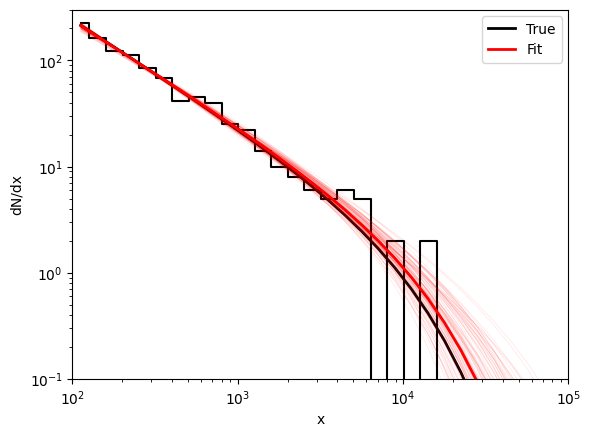

In [6]:
plt.step(10**logx, y, c='k', where='mid')
plt.plot(10**logx, powerlaw_expcutoff([A_true, beta_true, logxc_true], logx), c='k', lw=2, label='True')
plt.plot(10**logx, powerlaw_expcutoff([A, beta, logxc], logx), c='r', lw=2, label='Fit')

for A_boot, beta_boot, logxc_boot in zip(A_arr, beta_arr, logxc_arr):
    plt.plot(10**logx, powerlaw_expcutoff([A_boot, beta_boot, logxc_boot], logx), c='r', alpha=0.1, lw=0.5)

plt.legend()

plt.xlabel('x')
plt.ylabel('dN/dx')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2,1e5)
plt.ylim(1e-1,3e2)

plt.show()